Ispired by [Neural Network learns sine function using autodiff in JAX](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_network_sine_learning/nn_learns_sine_function_with_autodiff_in_jax.ipynb) and [Writing a training loop from scratch in JAX](https://keras.io/guides/writing_a_custom_training_loop_in_jax/)

In [1]:
import os

# Setting jax backend.
os.environ["KERAS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp
import keras
import optax
import matplotlib.pyplot as plt

In [2]:
# Set JAX to use GPU or CPU
jax.config.update('jax_default_device', jax.devices('gpu')[0])

In [3]:
# User-defined parameters
N_SAMPLES = 200
LEARNING_RATE = 0.01
REGULARIZATION_COEFF = 1e-3
N_EPOCHS = 30_000

In [4]:
key = jax.random.PRNGKey(10)

In [5]:
# Generating random data
key, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2*jnp.pi)
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.3

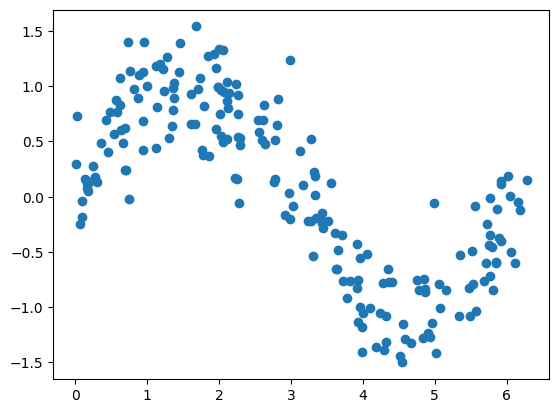

In [6]:
plt.scatter(x_samples, y_samples)

[jax.nn module, activation functions](https://jax.readthedocs.io/en/latest/jax.nn.html)

In [7]:
activation = jax.nn.sigmoid

[Keras dense layer](https://keras.io/api/layers/core_layers/dense/)

In [8]:
def get_model():
    inputs = keras.Input(shape=(1,), name="x")
    x1 = keras.layers.Dense(10, 
        activation=activation, use_bias=True, 
        kernel_initializer="glorot_uniform",
        activity_regularizer=keras.regularizers.L2(REGULARIZATION_COEFF)
        )(inputs)
    x2 = keras.layers.Dense(10, 
        activation=activation, use_bias=True, 
        kernel_initializer="glorot_uniform",
        activity_regularizer=keras.regularizers.L2(REGULARIZATION_COEFF)
        )(x1)
    x3 = keras.layers.Dense(10, 
        activation=activation, use_bias=True, 
        kernel_initializer="glorot_uniform",
        activity_regularizer=keras.regularizers.L2(REGULARIZATION_COEFF)
        )(x2)
    outputs = keras.layers.Dense(1, 
        use_bias=False, name="predictions"
        )(x3)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
model = get_model()

In [10]:
# Define a loss function.
def loss_fn(y, prediction):
    delta = prediction - y
    loss = jnp.mean(delta**2)
    return loss

In [11]:
def compute_loss_and_updates(trainable_variables, non_trainable_variables, x, y):
    y_pred, non_trainable_variables, losses = model.stateless_call(
        trainable_variables, non_trainable_variables, x, 
        training=True, return_losses=True
    )
    loss = loss_fn(y, y_pred)
    if losses:
        # Regularization: convert JAX array to float and add to the loss
        loss_value = (jnp.sum(jnp.array(losses)))
        loss += loss_value
    return loss, non_trainable_variables

In [12]:
grad_fn = jax.value_and_grad(compute_loss_and_updates, has_aux=True)

In [13]:
trainable_variables = model.trainable_variables
non_trainable_variables = model.non_trainable_variables

[Optax optimizers](https://optax.readthedocs.io/en/latest/api/optimizers.html)

In [14]:
# Optimizer
opt = optax.adam(LEARNING_RATE)
opt_state = opt.init(trainable_variables)

In [15]:
state = trainable_variables, non_trainable_variables, opt_state

In [16]:
@jax.jit
def train_step(state, data):
    trainable_variables, non_trainable_variables, opt_state = state
    x, y = data
    (loss, non_trainable_variables), grads = grad_fn(
        trainable_variables, non_trainable_variables, x, y
    )

    updates, opt_state = opt.update(grads, opt_state, trainable_variables)
    trainable_variables = optax.apply_updates(trainable_variables, updates)

    # Return updated state
    return loss, (
        trainable_variables,
        non_trainable_variables,
        opt_state
    )

In [17]:
# Training history callback
class HistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        self.history = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.history.append(logs['loss'])
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss {logs['loss']}")

In [18]:
# Create callback
history_callback = HistoryCallback()

In [19]:
# Training loop
for step in range(N_EPOCHS):
    data = (x_samples, y_samples)
    loss, state = train_step(state, data)
    history_callback.on_epoch_end(step, {"loss": loss})

Epoch 0, loss 5.496126651763916
Epoch 100, loss 0.9543185234069824
Epoch 200, loss 0.7869126796722412
Epoch 300, loss 0.6990834474563599
Epoch 400, loss 0.5997132062911987
Epoch 500, loss 0.47094014286994934
Epoch 600, loss 0.39504915475845337
Epoch 700, loss 0.3537319302558899
Epoch 800, loss 0.30990952253341675
Epoch 900, loss 0.2784741520881653
Epoch 1000, loss 0.2600497305393219
Epoch 1100, loss 0.24731040000915527
Epoch 1200, loss 0.23771896958351135
Epoch 1300, loss 0.23010723292827606
Epoch 1400, loss 0.22385400533676147
Epoch 1500, loss 0.21863383054733276
Epoch 1600, loss 0.21416407823562622
Epoch 1700, loss 0.21030005812644958
Epoch 1800, loss 0.20690132677555084
Epoch 1900, loss 0.20388251543045044
Epoch 2000, loss 0.20121103525161743
Epoch 2100, loss 0.1987820863723755
Epoch 2200, loss 0.1965835988521576
Epoch 2300, loss 0.19456914067268372
Epoch 2400, loss 0.1927424818277359
Epoch 2500, loss 0.19104096293449402
Epoch 2600, loss 0.18946920335292816
Epoch 2700, loss 0.188019

In [20]:
# Saving the model
trainable_variables, non_trainable_variables, optimizer_variables = state
for variable, value in zip(model.trainable_variables, trainable_variables):
    variable.assign(value)
for variable, value in zip(model.non_trainable_variables, non_trainable_variables):
    variable.assign(value)

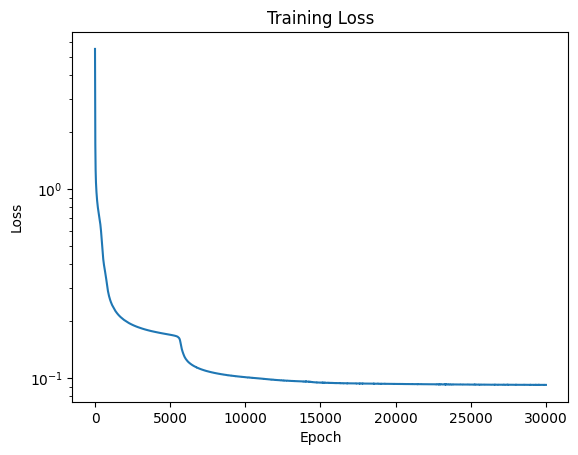

In [21]:
# Plot loss history
plt.figure(1)
plt.plot(history_callback.history)
plt.yscale("log")
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


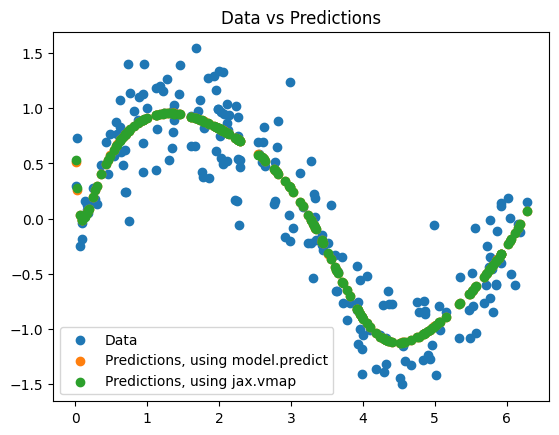

In [22]:
# Plot predictions vs actual data
plt.figure(2)
plt.scatter(x_samples, y_samples, label='Data')
plt.scatter(x_samples, model.predict(x_samples), 
            label='Predictions, using model.predict')
plt.scatter(x_samples, jax.vmap(model)(x_samples), 
            label='Predictions, using jax.vmap')
plt.legend()
plt.title('Data vs Predictions')
plt.show()